In [ ]:
from python_code.channel.modulator import BPSKModulator
from python_code.channel.channel_estimation import estimate_channel
from python_code.utils.metrics import calculate_error_rates
from python_code.ecc.rs_main import encode
import numpy as np
import torch


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"

In [ ]:
channel_type = 'ISI_AWGN'
memory_length = 4
noisy_est_var = 0
fading = False
fading_taps_type = 1
channel_coefficients = {'train': 'time_decay', 'val': 'time_decay'}
val_words = 1000
gamma = 0.2
n_states = 2 ** memory_length
snr = 10
phase = 'val'


In [6]:
block_length = 120
transmission_length = block_length
val_frames = 5
subframes_in_frame = 25
words = val_frames * subframes_in_frame
noise_seed = 3450002
word_seed = 7860002
rand_gen = np.random.RandomState(noise_seed)
word_rand_gen = np.random.RandomState(word_seed)
fading_in_channel = True
fading_in_decoder = True

In [ ]:
use_ecc = False
n_symbols = 2

if use_ecc:
    encoding = lambda b: encode(b, n_symbols)
else:
    encoding = lambda b: b

In [8]:
random = rand_gen
W_SIGMA = 1

def transmit(c: np.ndarray, h: np.ndarray, snr: float):
    """
    The AWGN Channel
    :param s: to transmit symbol words
    :param snr: signal-to-noise value
    :param random: random words generator
    :param h: channel function
    :param memory_length: length of channel memory
    :return: received word
    """
    if channel_type == 'ISI_AWGN':
        s = BPSKModulator.modulate(c)
        #### ISI AWGN channel ####
        snr_value = 10 ** (snr / 10)
        blockwise_s = np.concatenate([s[:, i:-memory_length + i] for i in range(memory_length)], axis=0)
        conv = np.dot(h[:, ::-1], blockwise_s)
        [row, col] = conv.shape
        w = (snr_value ** (-0.5)) * random.normal(0, W_SIGMA, (row, col))
        y = conv + w

    return y    

In [9]:
#### get_snr_data ####
def get_snr_data(snr: float, gamma: float, database: list):
    if database is None:
        database = []
    b_full = np.empty((0, block_length))
    y_full = np.empty((0, transmission_length))
    if phase == 'val':
        index = 0
    else:
        index = 0  # random.randint(0, 1e6)
    # accumulate words until reaches desired number
    while y_full.shape[0] < words:
        # generate word
        b = word_rand_gen.randint(0, 2, size=(1, block_length))
        # encoding - errors correction code
        c = encoding(b).reshape(1, -1)
        # add zero bits
        padded_c = np.concatenate([c, np.zeros([c.shape[0], memory_length])], axis=1)
        # transmit
        h = estimate_channel(memory_length, gamma,
                                channel_coefficients=channel_coefficients[phase],
                                noisy_est_var=noisy_est_var,
                                fading=fading_in_channel if phase == 'val' else fading_in_decoder,
                                index=index,
                                fading_taps_type=fading_taps_type)
        y = transmit(padded_c, h, snr)
        # accumulate
        b_full = np.concatenate((b_full, b), axis=0)
        y_full = np.concatenate((y_full, y), axis=0)
        index += 1

    database.append((b_full, y_full))

In [10]:
from typing import Tuple, List
import concurrent.futures

def get_item(snr_list: List[float], gamma: float) -> Tuple[torch.Tensor, torch.Tensor]:
    database = []
    # do not change max_workers
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        [executor.submit(get_snr_data, snr, gamma, database) for snr in snr_list]
    b, y = (np.concatenate(arrays) for arrays in zip(*database))
    b, y = torch.Tensor(b).to(device=device), torch.Tensor(y).to(device=device)
    return b, y

In [ ]:
from python_code.trainers.VA.va_trainer import VATrainer
dec = VATrainer()

# from python_code.trainers.BCJR.bcjr_trainer import BCJRTrainer
# dec = BCJRTrainer()

In [21]:
snr_list = [snr for snr in range(0, 21, 2)]
ser_list = []
for snr in snr_list:
    transmitted_words, received_words = get_item([snr], gamma)

    detected_words = dec.detector(received_words, 'val', snr, gamma)

    ser, fer, err_indices = calculate_error_rates(detected_words, transmitted_words)
    ser_list.append(ser)

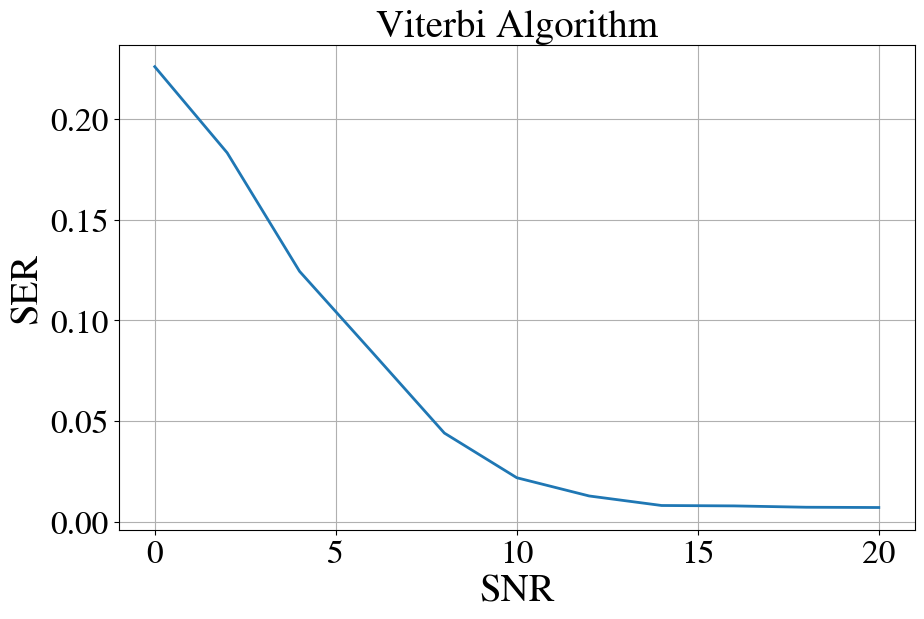

In [26]:
import matplotlib.pyplot as plt

plt.plot(snr_list, ser_list)
plt.xlabel('SNR')
plt.ylabel('SER')
plt.title('Viterbi Algorithm')
plt.grid()
plt.show()